# G-Conditional Diffusion model for Novel View Synthesis

This notebook is used to train and evaluate a diffusion-based refinement model for novel view synthesis in autonomous driving scenes. The model learns to enhance artifact-prone outputs (e.g., from DrivingForward or other 3DGS models) and produce higher-quality, photorealistic views ideally closer to the ground truth.


In [1]:
from dataloaders import get_dataloaders
import matplotlib.pyplot as plt
from train_cond_dm import train_diffusion_refiner
import torch
from eval_cond_dm import evaluate_model, show_comparison
%load_ext autoreload
%autoreload 2
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Using device: cuda


## Dataloading and Preprocessing

In [2]:
train_loader, val_loader = get_dataloaders("data", batch_size=4, num_workers=8)

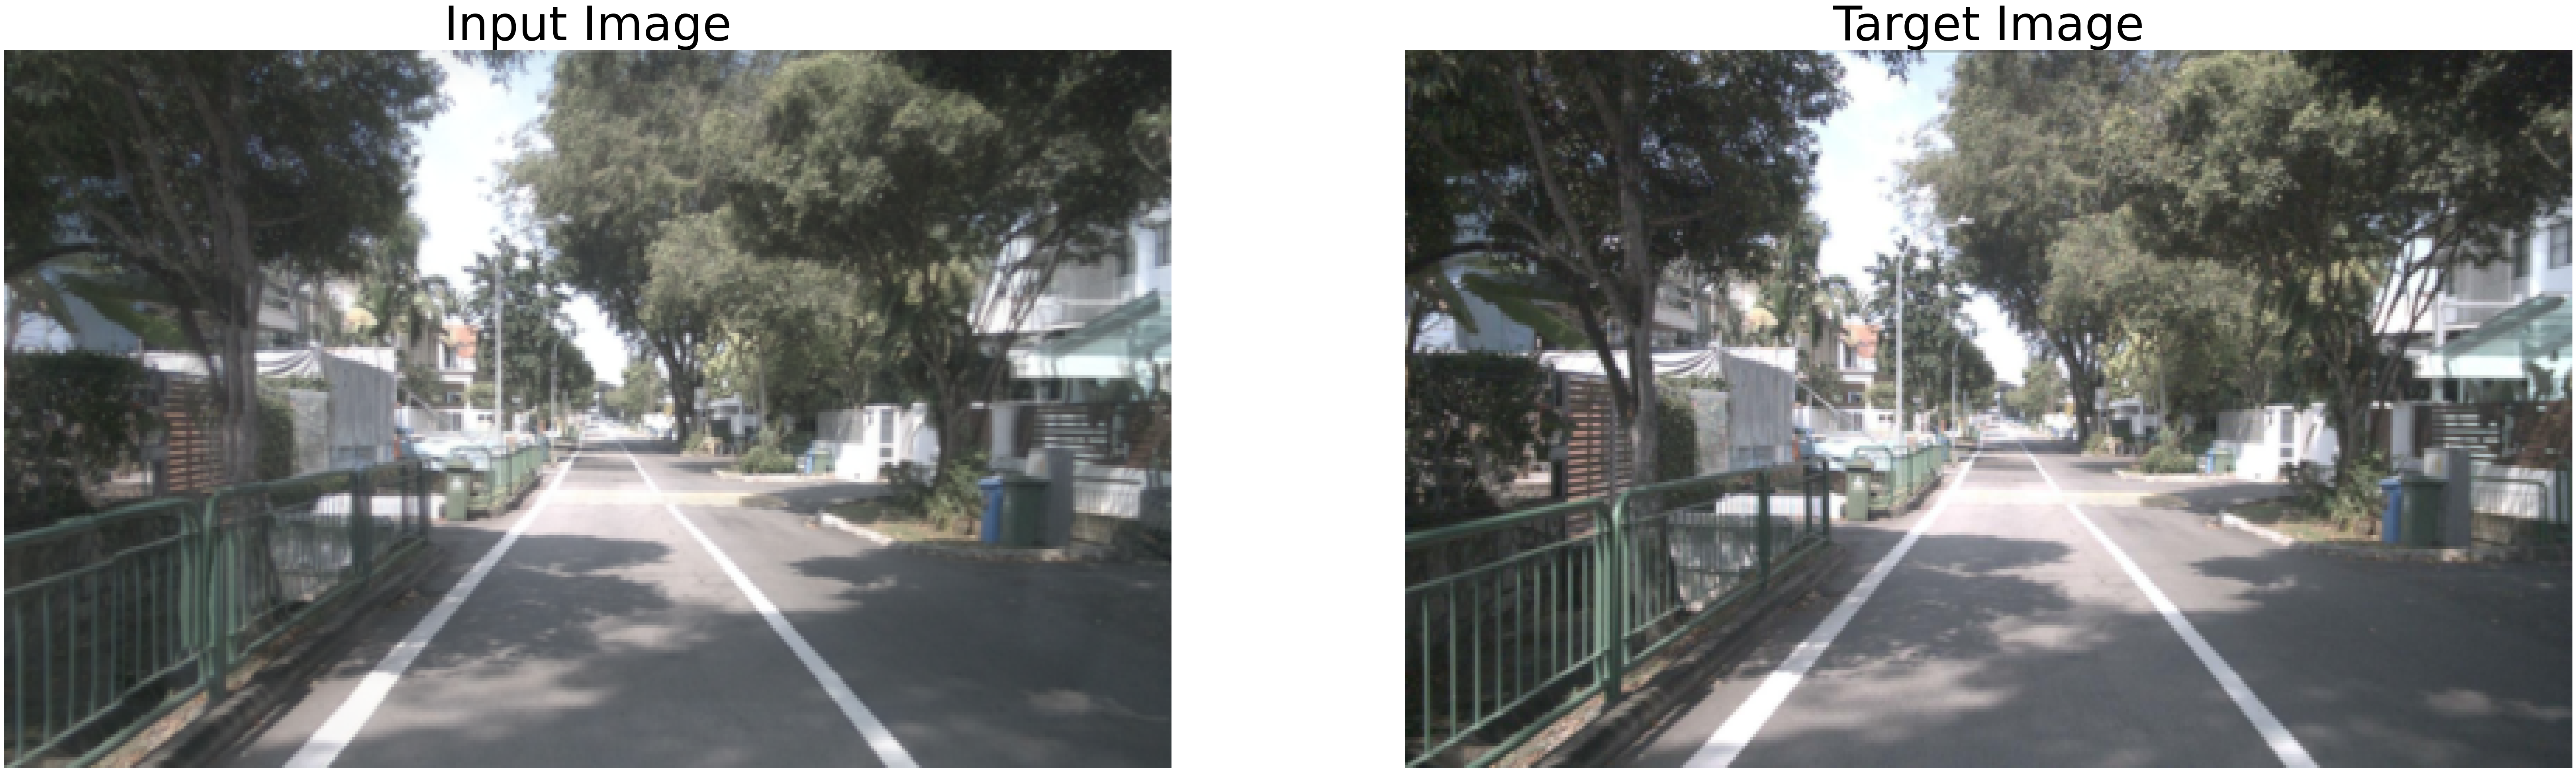

Batch number: 35, Batch size: 1
Sample index: 0
Input image shape: torch.Size([1, 3, 256, 416])
Target image shape: torch.Size([1, 3, 256, 416])
Token ID: 706c2bab659641a78137a6f9a34e2950


In [11]:
# ---------------------------------------------------------- #
# Select which batch and sample within that batch
batch_num = 35  # Select batch index (0-based)
sample_idx = 0  # Select sample within the batch (0-based)
# ---------------------------------------------------------- #
# Iterate through DataLoader to get the desired batch
for i, (x_batch, y_batch, token_ids) in enumerate(val_loader):
    if i == batch_num:
        break
else:
    raise ValueError(f"Batch {batch_num} does not exist in DataLoader.")

# Safety check
if sample_idx >= x_batch.shape[0]:
    raise ValueError(f"sample_idx {sample_idx} is out of range for batch size {x_batch.shape[0]}.")

input_height, input_width = x_batch.shape[2], x_batch.shape[3]
scale = 0.2

# Prepare images for display
input_img = x_batch[sample_idx].permute(1, 2, 0).cpu().numpy()
target_img = y_batch[sample_idx].permute(1, 2, 0).cpu().numpy()

# Normalize if necessary
if input_img.max() > 1.0:
    input_img = input_img / 255.0
if target_img.max() > 1.0:
    target_img = target_img / 255.0

input_img = input_img.clip(0, 1)
target_img = target_img.clip(0, 1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(input_width * scale, input_height * scale))
axes[0].imshow(input_img)
axes[0].set_title("Input Image", fontsize=86)
axes[0].axis("off")
axes[1].imshow(target_img)
axes[1].set_title("Target Image", fontsize=86)
axes[1].axis("off")
plt.show()

print(f"Batch number: {batch_num}, Batch size: {x_batch.shape[0]}")
print(f"Sample index: {sample_idx}")
print(f"Input image shape: {x_batch.shape}")
print(f"Target image shape: {y_batch.shape}")
print(f"Token ID: {token_ids[sample_idx]}")


## Training

In [6]:
train_diffusion_refiner(
    train_loader,
    val_loader,
    epochs=30,
    save_path="conditional_refiner_unet.pth",
    device="cuda" if torch.cuda.is_available() else "cpu",
    lr=1e-3
)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✅ Copied 440 pretrained weights into conditional model
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


Epoch 1/30 [Train]: 100%|██████████| 294/294 [05:26<00:00,  1.11s/it]


[Epoch 1] Train Loss: 0.0682


Epoch 1 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]


Val PSNR: 3.633 | SSIM: 0.002 | LPIPS: 0.922


Epoch 2/30 [Train]: 100%|██████████| 294/294 [05:26<00:00,  1.11s/it]


[Epoch 2] Train Loss: 0.0146


Epoch 2 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.87it/s]


Val PSNR: 3.299 | SSIM: 0.005 | LPIPS: 1.134


Epoch 3/30 [Train]: 100%|██████████| 294/294 [05:32<00:00,  1.13s/it]


[Epoch 3] Train Loss: 0.0113


Epoch 3 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.86it/s]


Val PSNR: 4.224 | SSIM: 0.009 | LPIPS: 1.144


Epoch 4/30 [Train]: 100%|██████████| 294/294 [05:28<00:00,  1.12s/it]


[Epoch 4] Train Loss: 0.0121


Epoch 4 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.82it/s]


Val PSNR: 1.026 | SSIM: 0.003 | LPIPS: 1.255


Epoch 5/30 [Train]: 100%|██████████| 294/294 [05:25<00:00,  1.11s/it]


[Epoch 5] Train Loss: 0.0116


Epoch 5 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.77it/s]


Val PSNR: 1.015 | SSIM: 0.003 | LPIPS: 1.261


Epoch 6/30 [Train]: 100%|██████████| 294/294 [05:30<00:00,  1.13s/it]


[Epoch 6] Train Loss: 0.0099


Epoch 6 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


Val PSNR: 3.324 | SSIM: 0.002 | LPIPS: 1.202


Epoch 7/30 [Train]: 100%|██████████| 294/294 [05:25<00:00,  1.11s/it]


[Epoch 7] Train Loss: nan


Epoch 7 [Val]: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]


Val PSNR: nan | SSIM: nan | LPIPS: nan


Epoch 8/30 [Train]: 100%|██████████| 294/294 [05:09<00:00,  1.05s/it]


[Epoch 8] Train Loss: nan


Epoch 8 [Val]:  39%|███▉      | 77/196 [00:11<00:18,  6.52it/s]


KeyboardInterrupt: 

In [5]:
evaluate_model(
        dataloader=val_loader,
        weights_path="conditional_refiner_unet.pth",
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_dir="eval_outputs",
        num_inference_steps= 25
    )

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


✅ Copied 440 pretrained weights into conditional model


Evaluating: 100%|██████████| 196/196 [09:57<00:00,  3.05s/it]


✅ Final Evaluation Metrics:
   PSNR: 9.215
   SSIM: 0.143
   LPIPS: 0.714


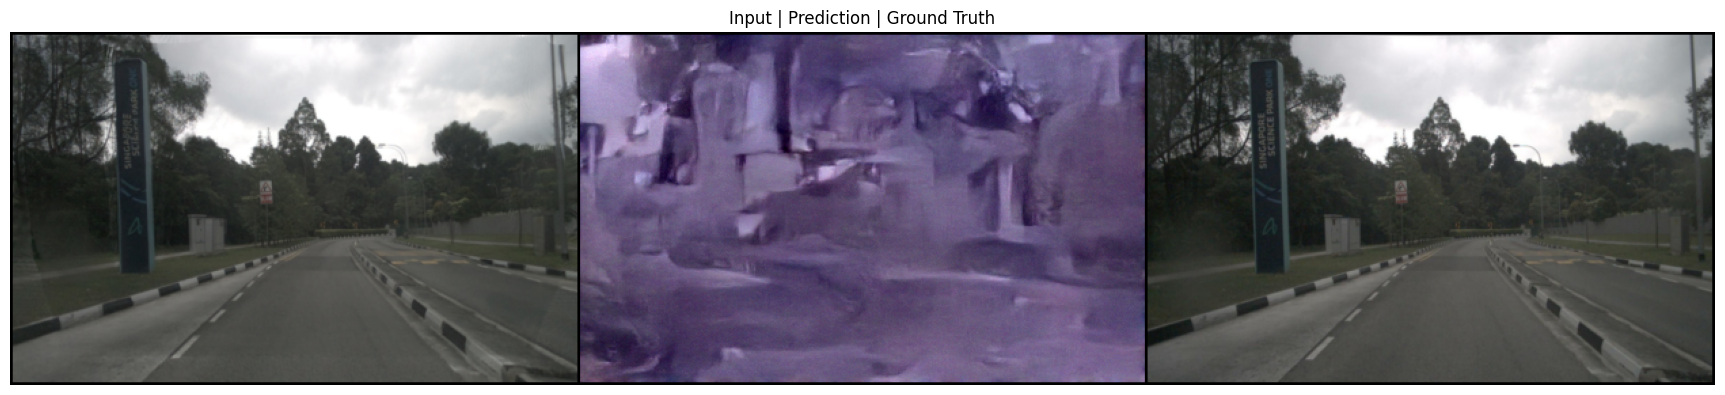

Input shape: torch.Size([3, 256, 416])
Prediction shape: torch.Size([3, 256, 416])
Ground Truth shape: torch.Size([3, 256, 416])


In [5]:
show_comparison('eval_outputs/9a466a62185f49929e4d66489d4be8e7')